## Import the necessary libraries.

In [11]:
# Built-in packages
import json
import warnings
import re
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier

sns.set(context= "notebook", color_codes=True)
plt.style.use('bmh')

%matplotlib inline
pd.set_option('display.max_columns', None)

**name**$~~~~~~~~~~~~~~~~~~~~~~~~~$- ASCII subject name and recording number
____
**MDVP:Fo(Hz)**$~~~~~~~~~~~~~$- Average vocal fundamental frequency
____
**MDVP:Fhi(Hz)**$~~~~~~~~~~~~$- Maximum vocal fundamental frequency
____
**MDVP:Flo(Hz)**$~~~~~~~~~~~~$- Minimum vocal fundamental frequency
____
**MDVP:Jitter(%), <br>
MDVP:Jitter(Abs), <br>
MDVP:RAP, <br>
MDVP:PPQ, <br>
Jitter:DDP**$~~~~~~~~~~~~~~~~~~$- Several measures of variation in fundamental frequency
____
**MDVP:Shimmer, <br>
MDVP:Shimmer(dB), <br>
Shimmer:APQ3, <br>
Shimmer:APQ5, <br>
MDVP:APQ, <br>
Shimmer:DDA**$~~~~~~~~~~~~~$- Several measures of variation in amplitude
____
**NHR,HNR**$~~~~~~~~~~~~~~~~~~~$- Two measures of ratio of noise to tonal components in the voice
____
**status**$~~~~~~~~~~~~~~~~~~~~~~~~$- Health status of the subject (one) - Parkinson's, (zero) - healthy
____
**RPDE,D2**$~~~~~~~~~~~~~~~~~~~~$- Two nonlinear dynamical complexity measures
____
**DFA**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Signal fractal scaling exponent
____
**spread1, <br>
spread2, <br>
PPE**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Three nonlinear measures of fundamental frequency variation
____

## Read the data as a data frame

The extention of the file is **.data** but can be read like a regular **csv** file because the data inside is still comma separated.

The column names have special characters and we can clean them using string manipulation functions and regex.

In [12]:
# Read the CSV file and display first 10 rows
df = pd.read_csv("./parkinsons.data")
df.columns = [i.replace(" ", "_").replace("(%)", "_perc").replace("(dB)", "_db").replace(":", "_").lower() for i in df.columns]
df.columns = [re.sub(r"\((.+)\)", "", i) for i in df.columns]

df.head(10)

,name,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_jitter,mdvp_rap,mdvp_ppq,jitter_ddp,mdvp_shimmer,mdvp_shimmer_db,shimmer_apq3,shimmer_apq5,mdvp_apq,shimmer_dda,nhr,hnr,status,rpde,dfa,spread1,spread2,d2,ppe
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
5,phon_R01_S01_6,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,0.02328,0.03526,0.03243,0.06985,0.01222,21.378,1,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
6,phon_R01_S02_1,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,0.00779,0.00937,0.01351,0.02337,0.00607,24.886,1,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756
7,phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,0.134,0.00829,0.00946,0.01256,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
8,phon_R01_S02_3,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,0.191,0.01073,0.01277,0.01717,0.03218,0.01070,21.812,1,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571
9,phon_R01_S02_4,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,0.255,0.01441,0.01725,0.02444,0.04324,0.01022,21.862,1,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362


In [13]:
print(f"The shape of the DatFrame is: {df.shape}, which means there are {df.shape[0]} rows and {df.shape[1]} columns.")

The shape of the DatFrame is: (195, 24), which means there are 195 rows and 24 columns.


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
mdvp_fo             195 non-null float64
mdvp_fhi            195 non-null float64
mdvp_flo            195 non-null float64
mdvp_jitter_perc    195 non-null float64
mdvp_jitter         195 non-null float64
mdvp_rap            195 non-null float64
mdvp_ppq            195 non-null float64
jitter_ddp          195 non-null float64
mdvp_shimmer        195 non-null float64
mdvp_shimmer_db     195 non-null float64
shimmer_apq3        195 non-null float64
shimmer_apq5        195 non-null float64
mdvp_apq            195 non-null float64
shimmer_dda         195 non-null float64
nhr                 195 non-null float64
hnr                 195 non-null float64
status              195 non-null int64
rpde                195 non-null float64
dfa                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

There are no null values in any of the columns.

In [15]:
df_summary = df.describe()
df_summary

,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_jitter,mdvp_rap,mdvp_ppq,jitter_ddp,mdvp_shimmer,mdvp_shimmer_db,shimmer_apq3,shimmer_apq5,mdvp_apq,shimmer_dda,nhr,hnr,status,rpde,dfa,spread1,spread2,d2,ppe
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Observations: 

* There are 195 rows and 24 columns with no null values in any of the columns.
* We need to remove the **name** column as it adds no value to our dataset.
* Looking at the summary of the dataset, looks like a lot of columns have outliers but they could be important to us.

## EDA

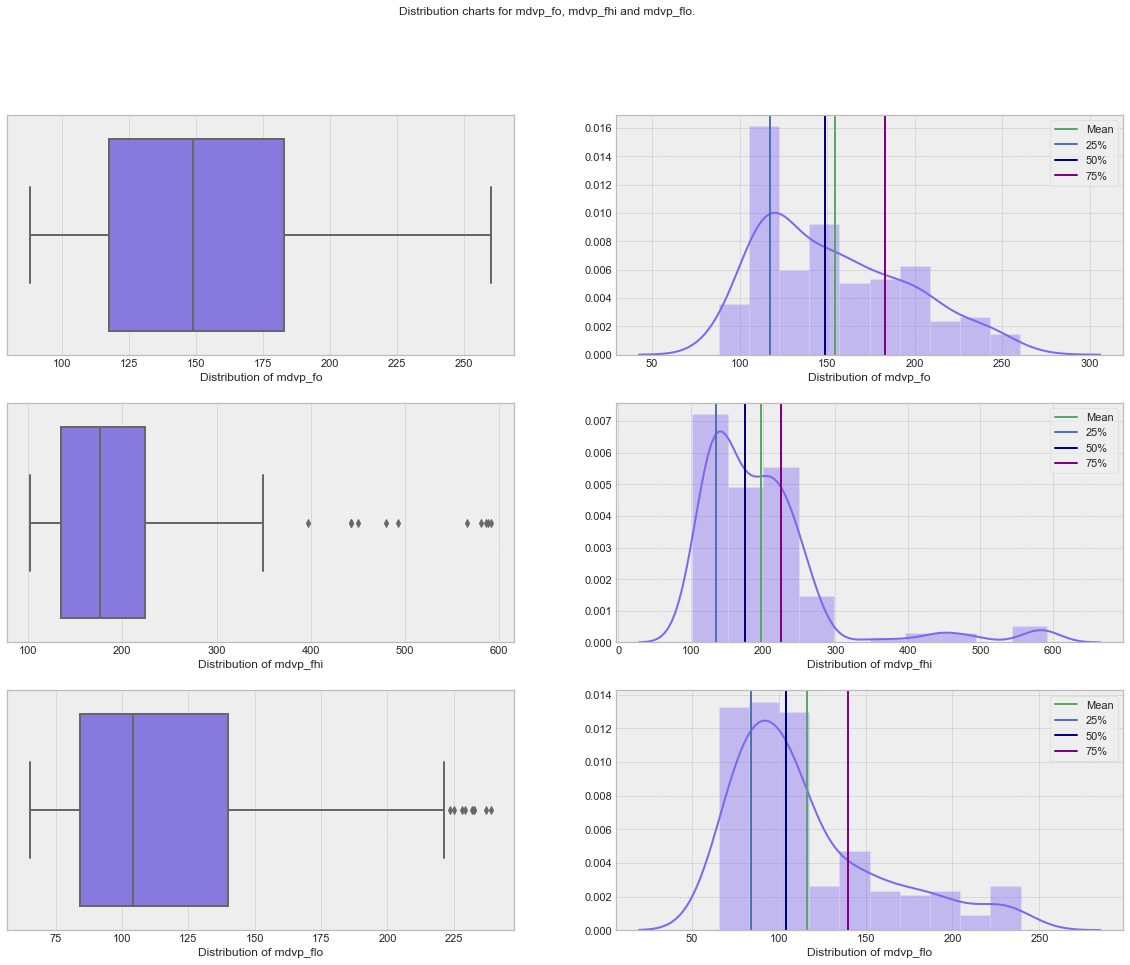

In [16]:
def draw_axvlines(plt, col):
    mean = df_summary.loc["mean", col]
    q1 = df_summary.loc["25%", col]
    q2 = df_summary.loc["50%", col]
    q3 = df_summary.loc["75%", col]
    plt.axvline(mean, color = "g");              # Plotting a line to mark the mean 
    plt.axvline(q1, color = "b");                # Plotting a line to mark Q1 
    plt.axvline(q2, color = "navy");             # Plotting a line to mark Q2 
    plt.axvline(q3, color = "purple");           # Plotting a line to mark Q3
    plt.legend({"Mean": mean, "25%" : q1, "50%" : q2, "75%" : q3});

fig, axes = plt.subplots(3, 2, figsize = (20,15));
fig.suptitle('Distribution charts for mdvp_fo, mdvp_fhi and mdvp_flo.');


# Create boxplot to show distribution of Age
sns.boxplot(df["mdvp_fo"], ax = axes[0][0], color = "mediumslateblue");
axes[0][0].set(xlabel = 'Distribution of mdvp_fo');

pp = sns.distplot(df["mdvp_fo"], ax = axes[0][1], bins = 10, color = "mediumslateblue");
axes[0][1].set(xlabel = 'Distribution of mdvp_fo');
draw_axvlines(pp, "mdvp_fo");


# Create boxplot to show distribution of creatinine_phosphokinase
sns.boxplot(df["mdvp_fhi"], ax = axes[1][0], color = "mediumslateblue");
axes[1][0].set(xlabel = 'Distribution of mdvp_fhi');

pp = sns.distplot(df["mdvp_fhi"], ax = axes[1][1], bins = 10, color = "mediumslateblue");
axes[1][1].set(xlabel = 'Distribution of mdvp_fhi');
draw_axvlines(pp, "mdvp_fhi")


# Create boxplot to show distribution of platelets
sns.boxplot(df["mdvp_flo"], ax = axes[2][0], color = "mediumslateblue");
axes[2][0].set(xlabel = 'Distribution of mdvp_flo');

pp = sns.distplot(df["mdvp_flo"], ax = axes[2][1], color = "mediumslateblue");
axes[2][1].set(xlabel = 'Distribution of mdvp_flo');
draw_axvlines(pp, "mdvp_flo")

Observations:
* All the above distribution plots are right skewed.
* There are a few outliers in mdvp_fhi and mdvp_flo.
* The amount of patients with mdvp_fo in the range Q1-Q2 is almost the same as patients with mdvp_fo in the range Q2-Q3.

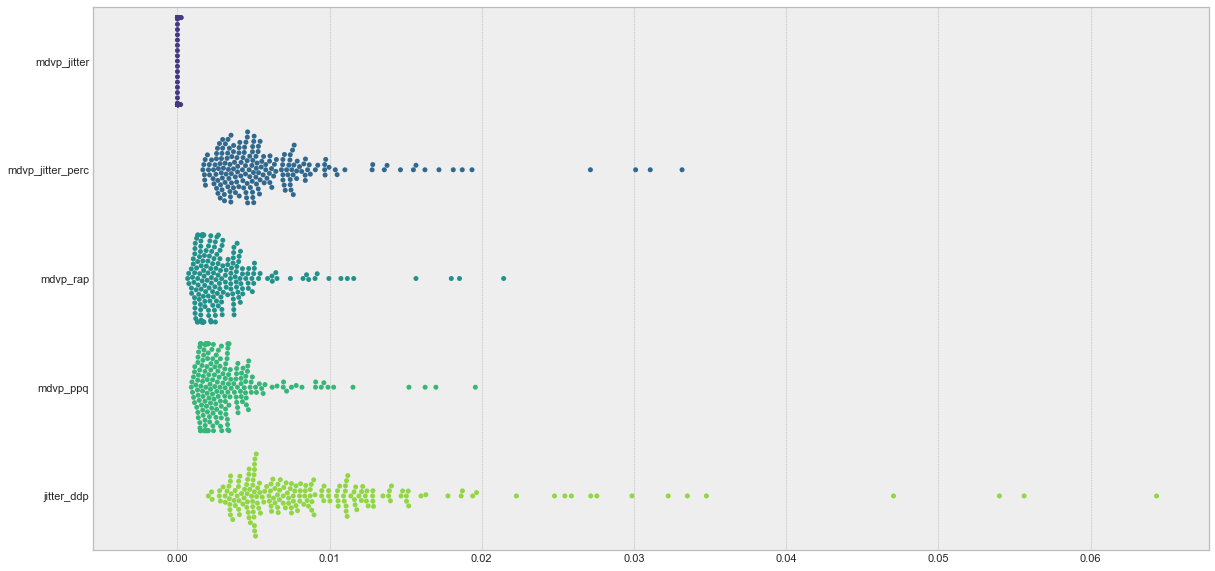

In [17]:
plt.figure(figsize = (20, 10))
sns.swarmplot(data=df[["mdvp_jitter", "mdvp_jitter_perc", "mdvp_rap", "mdvp_ppq", "jitter_ddp"]], orient="h", palette="viridis");

The column **jitter_ddp** has a wider spread when compared to the other columns.

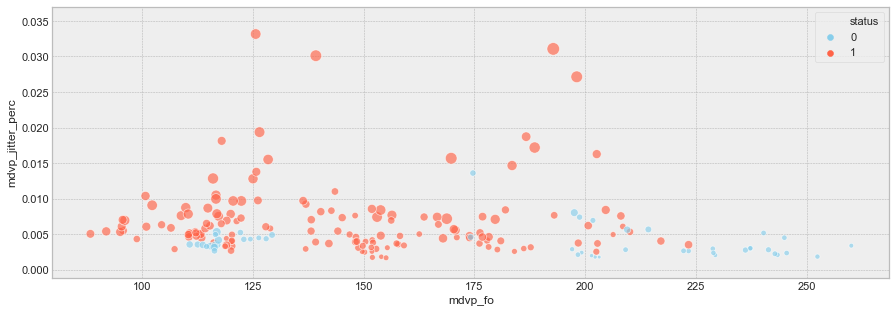

In [18]:
plt.figure(figsize = (15, 5))
sns.scatterplot(x = "mdvp_fo", y = "mdvp_jitter_perc", data = df[["mdvp_fo", "ppe", "mdvp_jitter_perc", "status"]], hue = "status", alpha = 0.65, palette=["skyblue", "tomato"], s=df["ppe"]*300);

Observation:

* It is clear from the above scatter plot that people that do not have the Parkinson's disease mostly have a mdvp jitter percentage of less that 0.005%. We can see clear clusters for the two classes.
* The jitter percentage is usually higher for Parkinsons affected people.
* The **ppe** for people with Parkinsons is also higher than people that do not have Parkinsons show by the blob sizes.

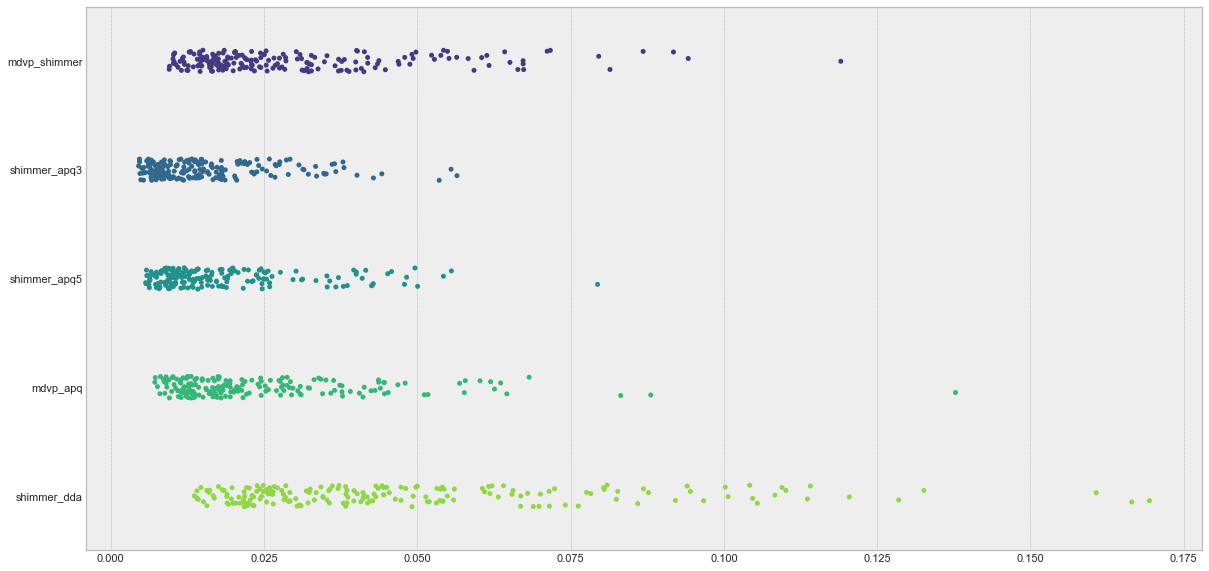

In [19]:
plt.figure(figsize = (20, 10))
sns.stripplot(data=df[["mdvp_shimmer", "shimmer_apq3", "shimmer_apq5", "mdvp_apq", "shimmer_dda"]], orient="h", palette="viridis");

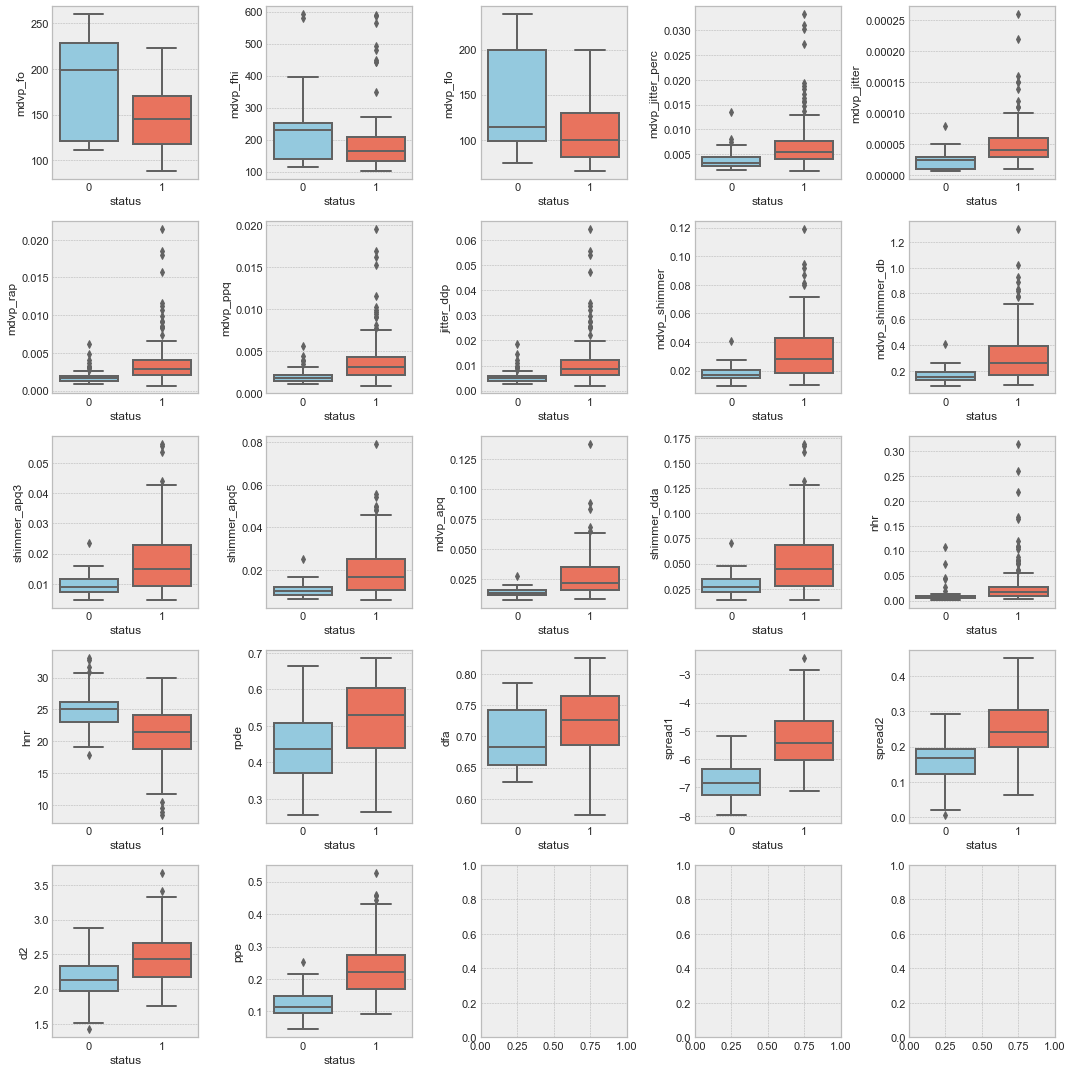

In [23]:
fig, axes = plt.subplots(5, 5, figsize = (15,15));

cols = df.columns.tolist()
cols.remove("name")
cols.remove("status")

count = 0
for r in range(0,5):
    for c in range(0,5):
        if count < len(cols):
            sns.boxplot(x="status", y=cols[count], data=df, ax=axes[r,c], orient="v", palette=["skyblue", "tomato"])
            count += 1
            
plt.tight_layout()

Observations:

* Looking at all the boxplots, most of the boxplots for people with the Parkinsons disease have values higher than people without the disease.
* The range of values in the column **rpde** is the same for people with and without Parkinsons disease.
* The columns **spread1**, **spread2** and **ppe** show a distinct difference in the distribution between values for people with and without Parkinsons which are the three nonlinear measures of fundamental frequency variation.

In [24]:
df_train = df.drop(columns=["mdvp_jitter","mdvp_rap","mdvp_ppq","jitter_ddp","mdvp_shimmer_db","shimmer_apq3","shimmer_apq5","mdvp_apq" ,"shimmer_dda"])

col_names = df_train.columns.tolist()
col_names.remove("name")
col_names.remove("status")

target_col = ["status"]
df_train = df_train[col_names + target_col]

* **From the above charts, many of them provide us the same information and are highly correlated to each other, we will remove all these columns except one from each of those two groups so that our models get created faster and efficiently.**

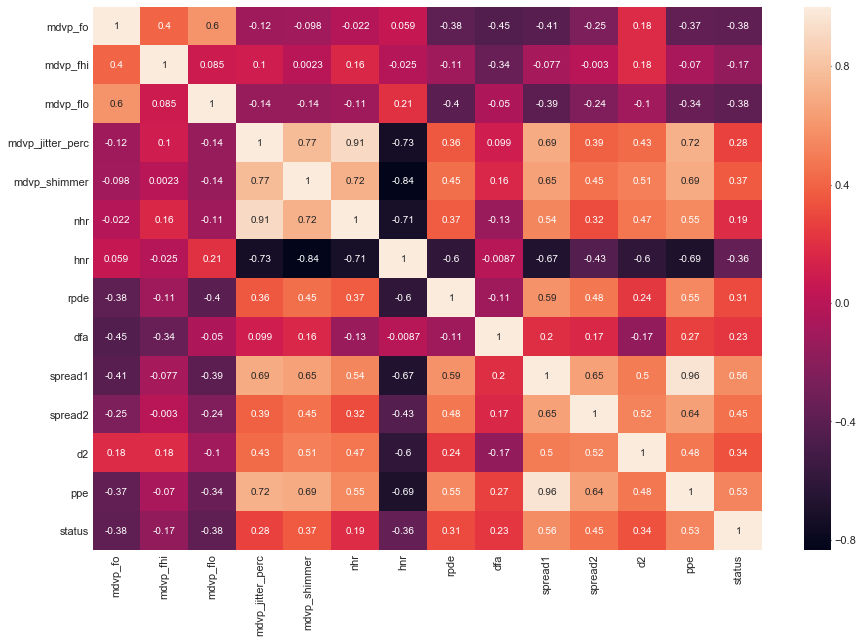

In [25]:
plt.figure(figsize=(15,10))
corr = df_train.corr()
sns.heatmap(corr, annot=True, fmt='.2g');

* The above correlation heat map shows that the columns **spread1**, **spread2** and **ppe** are significantly correlated to the **status** column.
* The column **mdvp_fhi** does not have much correlation to the **status** column.

### Target column distribution

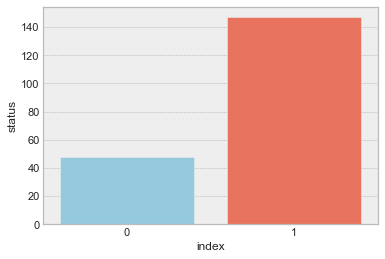

In [26]:
xx = df_train["status"].value_counts().reset_index()
sns.barplot(x="index", y="status", data=xx, palette = ["skyblue", "tomato"])

The dataset is highly imbalanced with a ratio of 25:75. The dataset contains more data for people with the Parkinsons disease.

## Standardization (Scaling)

In [27]:
std = StandardScaler()

scaled = std.fit_transform(df_train[col_names])     # Standardize the columns to get them on the same scale
scaled = pd.DataFrame(scaled, columns=col_names)

df_train = pd.concat([scaled, df_train[target_col]], axis=1)

df_train.head()

,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_shimmer,nhr,hnr,rpde,dfa,spread1,spread2,d2,ppe,status
0,-0.829300,-0.436165,-0.952037,0.334914,0.745985,-0.067893,-0.193225,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886,1
1,-0.770972,-0.530974,-0.057721,0.715418,1.681731,-0.137843,-0.634508,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605,1
2,-0.909476,-0.723168,-0.109875,0.884991,1.202693,-0.291633,-0.279760,-0.662075,1.942048,1.141445,1.017682,-0.103629,1.402661,1
3,-0.909622,-0.649092,-0.114229,0.775389,1.340396,-0.280719,-0.281346,-0.613134,1.832380,1.440945,1.293840,0.062145,1.806954,1
4,-0.925657,-0.606245,-0.130608,1.368893,1.836448,-0.178026,-0.506745,-0.783021,1.909364,1.780940,0.096195,-0.130026,2.267082,1


## Test AND Train split 70:30 ratio

In [28]:
X = df_train[col_names]      # Contains the independent columns 
y = df_train[target_col]     # Our target column

In [29]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 323)
train_y = train_y["status"]
test_y = test_y["status"]

## Models

In [30]:
conf_matrix_all = {}

def parkinsons_disease_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Fit the training data set to the algorithm passed.
    predictions = algo.predict(testing_x)                     # Get all predictions
    probabilities = algo.predict_proba(testing_x)             # Get probablities of predictions

    conf_matrix = confusion_matrix(testing_y, predictions)    # Get confusion matrix using the predictions
    tn, fp, fn, tp = conf_matrix.ravel()
    
    conf_matrix_all[name] = conf_matrix                       # Save confusion matrix values to a dictionary
    
    print("Classification report:")                           # Print the classification report
    print(classification_report(testing_y, predictions))
  
    model_roc_auc = roc_auc_score(testing_y, predictions)           # Get the Area under the curve number
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Get False postive rate and true positive rate
    
    print ("Area under the curve: ", model_roc_auc)
    print("Accuracy score: ", accuracy_score(testing_y, predictions))
    
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(20, 7))
        conf_matrix = np.flip(conf_matrix)
        
        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)
        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[0], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);                                           # Plot the confusion matrix
        axes[0].set(xlabel='Predicted', ylabel='Actual')

        plt.title('Receiver Operating Characteristic')
        sns.lineplot(fpr, tpr, ax=axes[1])                                         # Plot the ROC curve
        plt.plot([0, 1], [0, 1],'--')                                              # Plot the diagonal line
        axes[1].set_xlim([0, 1])                                                   # Set x-axis limit to 0 and 1
        axes[1].set_ylim([0, 1])                                                   # Set y-axis limit to 0 and 1
        axes[1].set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate');
        plt.show();

### Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.96      0.94      0.95        47

    accuracy                           0.92        59
   macro avg       0.86      0.88      0.87        59
weighted avg       0.92      0.92      0.92        59

Area under the curve:  0.8847517730496455
Accuracy score:  0.9152542372881356


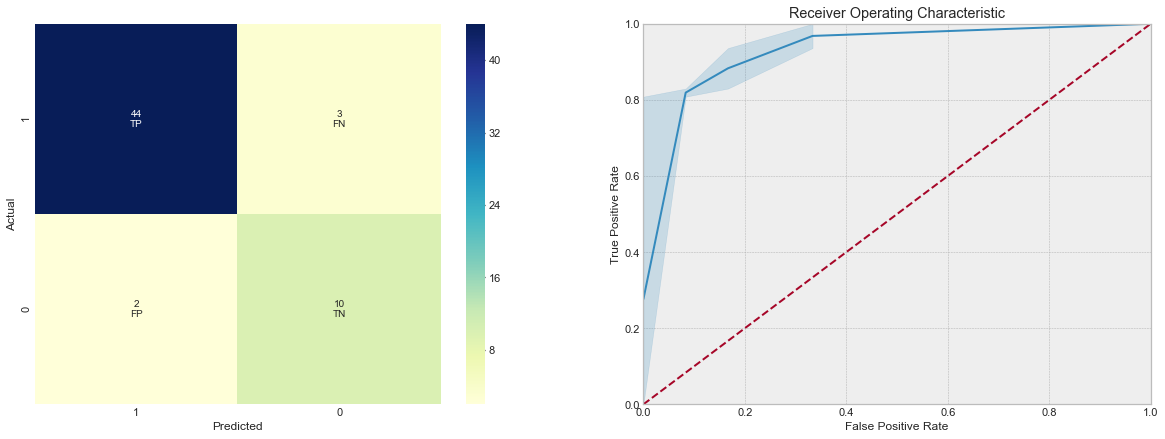

In [31]:
lr  = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, penalty="l1", solver='liblinear')

parkinsons_disease_prediction("Logistic Regression", lr, train_X, test_X, train_y, test_y, plot = True)

### K-nearest Neighbors

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.96      0.98        47

    accuracy                           0.97        59
   macro avg       0.93      0.98      0.95        59
weighted avg       0.97      0.97      0.97        59

Area under the curve:  0.9787234042553192
Accuracy score:  0.9661016949152542


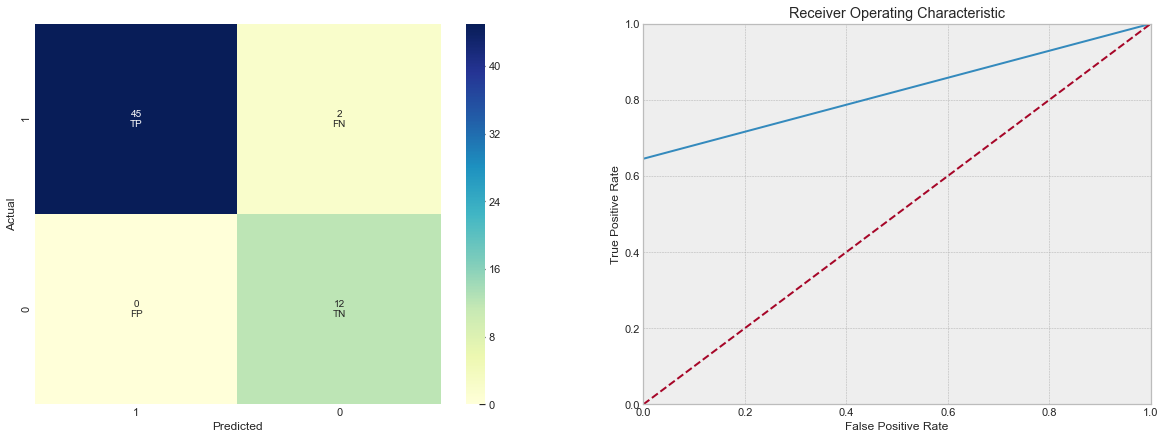

In [32]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')

parkinsons_disease_prediction("K-Nearest Neighbours", knn, train_X, test_X, train_y, test_y, plot=True)

### Naïve Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.92      0.65        12
           1       0.97      0.77      0.86        47

    accuracy                           0.80        59
   macro avg       0.74      0.84      0.75        59
weighted avg       0.88      0.80      0.81        59

Area under the curve:  0.8413120567375886
Accuracy score:  0.7966101694915254


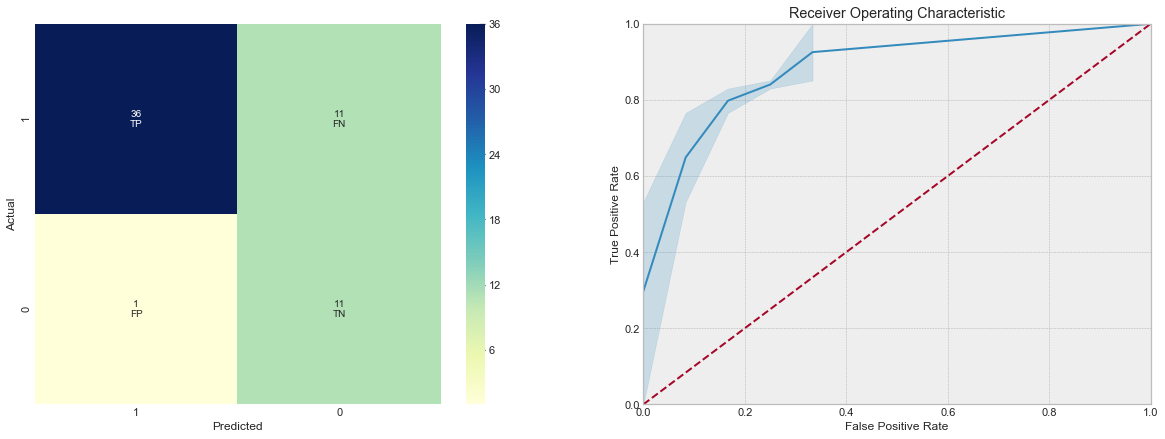

In [33]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)

parkinsons_disease_prediction("Gaussian Naïve Bayes", gnb, train_X, test_X, train_y, test_y, plot=True)

### Support Vector Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.96      0.96      0.96        47

    accuracy                           0.93        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.93      0.93      0.93        59

Area under the curve:  0.8953900709219859
Accuracy score:  0.9322033898305084


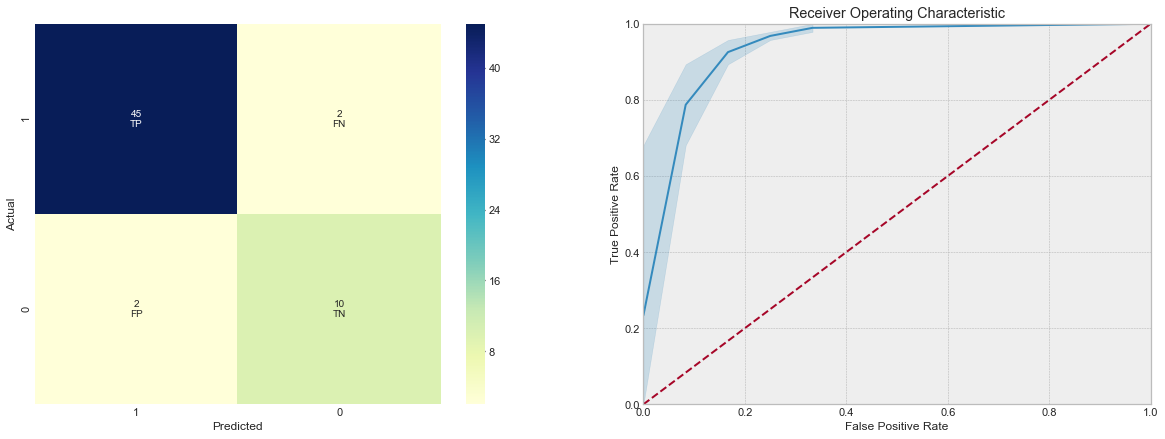

In [34]:
svc = SVC(C=1.0, kernel='linear', degree= 2, gamma=1.0, random_state=None,
          coef0=0.0, shrinking=True, probability=True,tol=0.001,
          cache_size=200, class_weight=None, verbose=False,max_iter= -1)

parkinsons_disease_prediction("Support Vector Classifier", svc, train_X, test_X, train_y, test_y, plot=True)

## Stack and train meta-classifier

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.96      0.98        47

    accuracy                           0.97        59
   macro avg       0.93      0.98      0.95        59
weighted avg       0.97      0.97      0.97        59

Area under the curve:  0.9787234042553192
Accuracy score:  0.9661016949152542


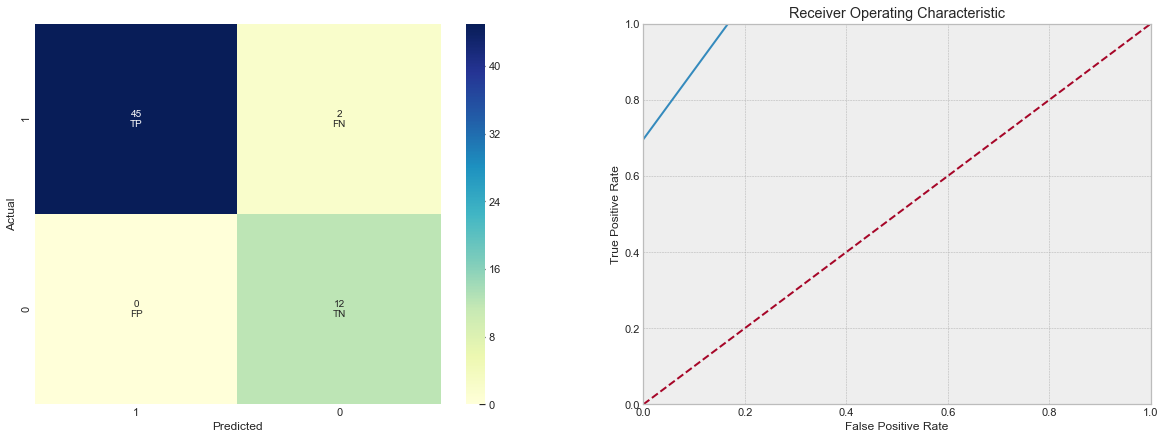

In [35]:
sclf = StackingCVClassifier(classifiers=[lr, knn, svc], meta_classifier=LogisticRegression(), random_state=42)

parkinsons_disease_prediction("Stacking Classifier", sclf, train_X, test_X, train_y, test_y, plot=True)

## Ensemble models

### Random Forest

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.98      0.98      0.98        47

    accuracy                           0.97        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.97      0.97      0.97        59

Area under the curve:  0.9476950354609928
Accuracy score:  0.9661016949152542


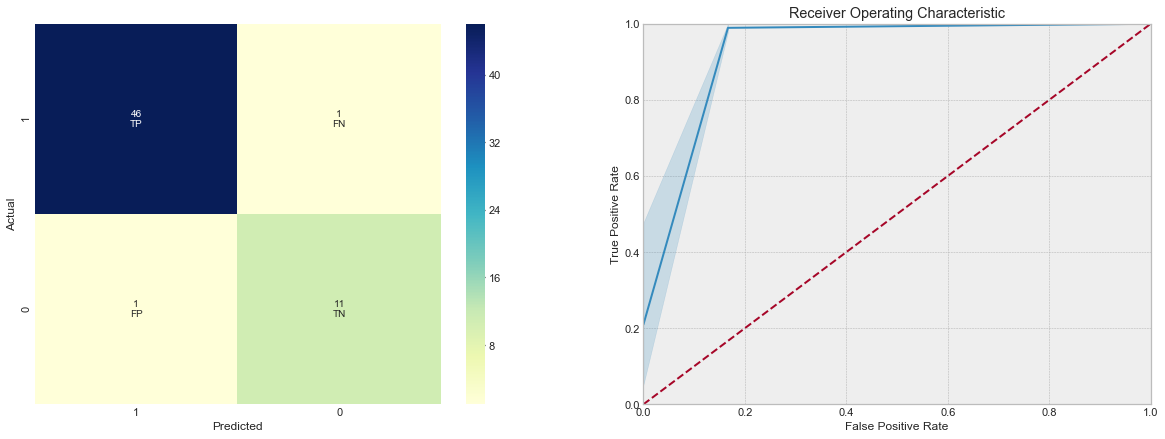

In [36]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, criterion = "gini", 
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

parkinsons_disease_prediction("Random Forest", rfc,train_X,test_X,train_y,test_y, plot=True) 

### Bagging Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.96      0.98      0.97        47

    accuracy                           0.95        59
   macro avg       0.93      0.91      0.92        59
weighted avg       0.95      0.95      0.95        59

Area under the curve:  0.9060283687943261
Accuracy score:  0.9491525423728814


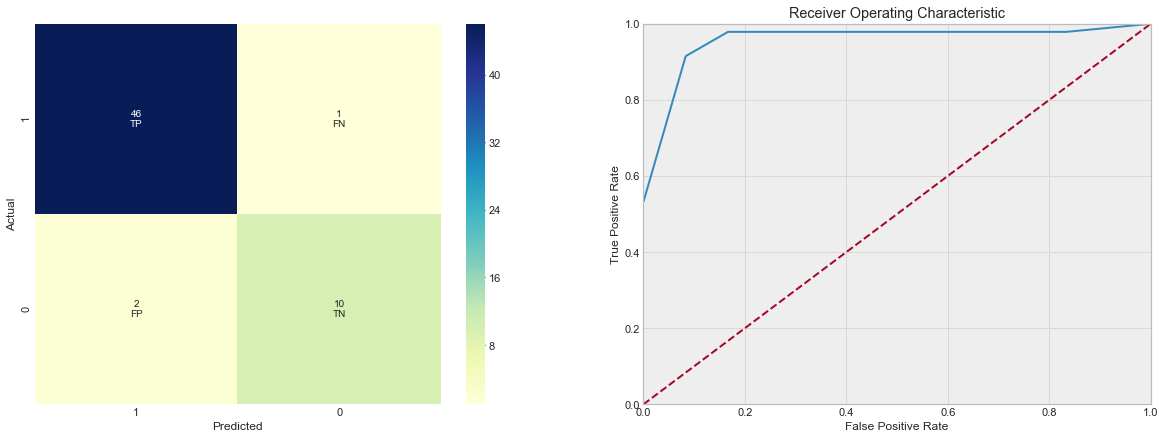

In [37]:
bcc = BaggingClassifier()

parkinsons_disease_prediction("Bagging Classifier", bcc,train_X,test_X,train_y,test_y, plot=True) 

### Adaptive boosting classifier

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.96      1.00      0.98        47

    accuracy                           0.97        59
   macro avg       0.98      0.92      0.94        59
weighted avg       0.97      0.97      0.96        59

Area under the curve:  0.9166666666666667
Accuracy score:  0.9661016949152542


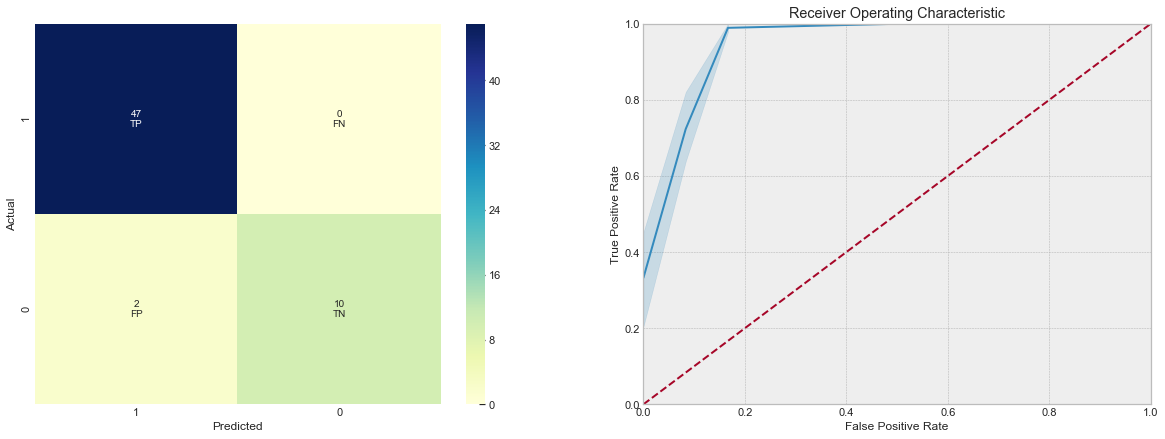

In [38]:
abc = AdaBoostClassifier(base_estimator=None, learning_rate=0.06, algorithm='SAMME.R')


parkinsons_disease_prediction("AdaBoost", abc, train_X, test_X, train_y, test_y, plot=True)

### Gradient Boosting (XGBoost)

Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.98      0.99        47

    accuracy                           0.98        59
   macro avg       0.96      0.99      0.97        59
weighted avg       0.98      0.98      0.98        59

Area under the curve:  0.9893617021276595
Accuracy score:  0.9830508474576272


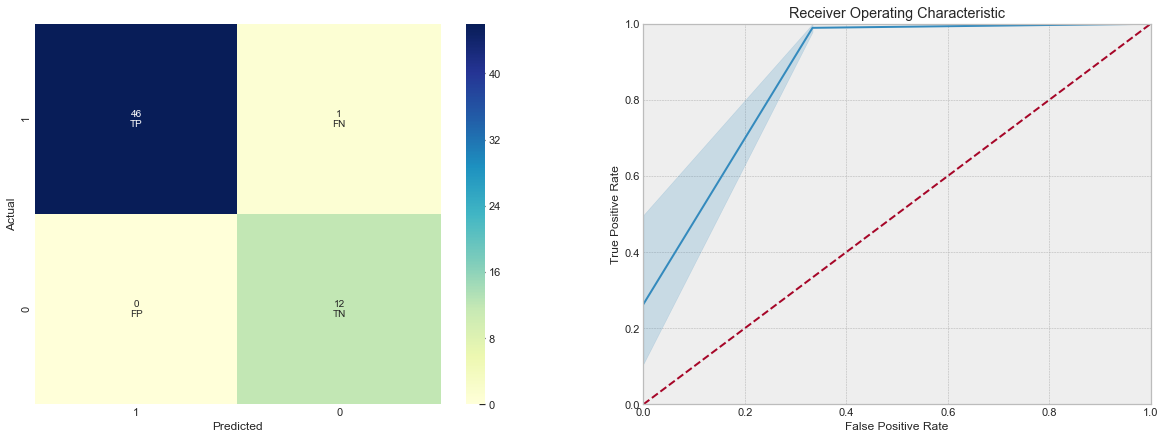

In [39]:
xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth = 6, min_child_weight=1, missing=None, n_estimators=50,
                        objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, subsample=0.8)

parkinsons_disease_prediction("XGBoost", xgc, train_X, test_X, train_y, test_y, plot=True)

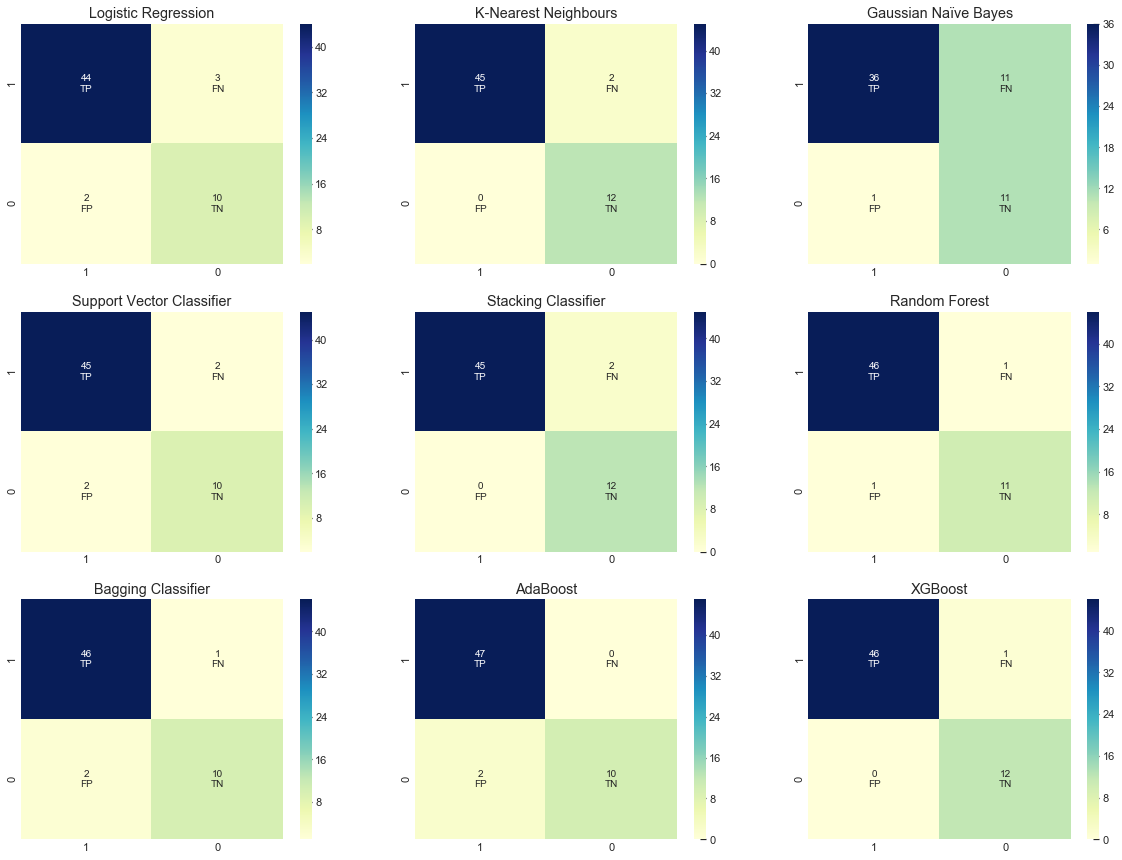

In [40]:
import math
fig, axes = plt.subplots(3,3, figsize = (20, 15))

cnt = 0
for r in range(4):
    for c in range(4):
        try:
            conf_matrix = np.flip(list(conf_matrix_all.values())[cnt])
            labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
            labels = np.core.defchararray.add(conf_matrix.astype(str), labels)

            sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[r, c], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);
            axes[r, c].set(title=list(conf_matrix_all.keys())[cnt])
            cnt += 1
        except:
            pass

## The best model?

* Looking at the accurary of all our models, the **K-Nearest Neighbors** classifier gives us the best fit for our model amongst all the standard classification algorithms but overall the **XGBoost classifier** give us the highest accuracy score of **0.983**.
* The **Naïve Bayes** model has the lowest accuracy and AUC for our dataset and is the worst performing model of the lot. The **Logistic Regression** and the **Support Vector Classifier** models performs significantly better than **Naïve Bayes**.
* The **Stacking classifier** that uses a **meta classifier** also has a great accuracy of **0.966** which is the second best after **XGBoost**.
* The Type I and Type II errors are also lower for the **XGBoost** model comparatively.
* The Area under the curve (AUC) of **0.989** is also the highest for the **XGBoost** model.
* The other metrics such as Recall and F1 score which are **0.98** and **0.99** respectively for the **XGBoost classifier** model are also the highest.

**Hence the model that does the best job at predicting our target column is the XGBoost classifier.**